# Exercise 6: Oil Inventory Estimation

In [2]:
import os
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries
from skimage.exposure import histogram
from skimage.morphology import remove_small_objects, binary_closing, skeletonize
from scipy.ndimage.interpolation import rotate

## Example Images

Some example images of oil refinery sites where taken from [here](https://blog.spaceknow.com/cushing/). The examples are DigitalGlobe imagery.

In [17]:
PX_TO_M = 1.65 # assuming digital globe GeoEye-1 panchromatic

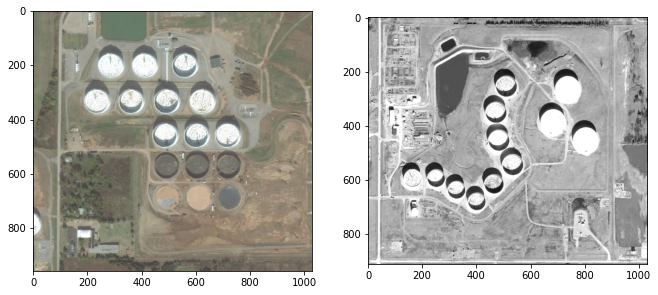

In [4]:
tank = plt.imread('storage_tanks.jpg')
tank1 = plt.imread('storage_tanks_2.jpg')
f = plt.figure(figsize=(11, 11))
ax = f.add_subplot(121)
ax.imshow(tank, cmap='gray')
ax1 = f.add_subplot(122)
ax1.imshow(tank1, cmap='gray')

### Bounding Box Detection 

We can simulate the detection by simply cropping one of the tanks from the above image.

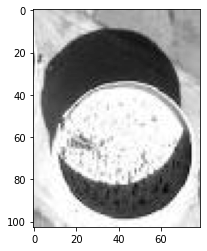

In [5]:
img = cv2.imread('tank_3.jpg', 0)
plt.imshow(img, cmap='gray')

### Pixel Histogram

Plotting the distribution of the pixel values shows there is good potential for thresholding. 

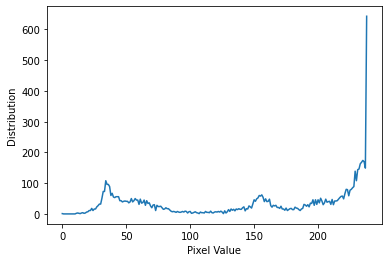

In [7]:
hist, hist_centers = histogram(img)
plt.ylabel('Distribution')
plt.xlabel('Pixel Value')
plt.plot(hist)

### Smooth and Otsu Thresholding

We can smooth out the image by convolving with a Gaussian filter. This removes some of the noise. Then we can apply Otsu thresholding, which applies a threshold value based on the global image values. 

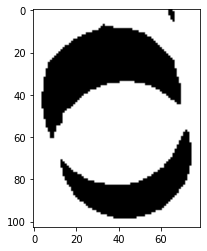

In [8]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret, img = cv2.threshold(blur, 255, 255, cv2.THRESH_OTSU)
plt.imshow(img, cmap='gray')

### Invert and further noise removal

Our regions of interest should ideally be non-zero, so we invert the values and remove the rest of the noise.

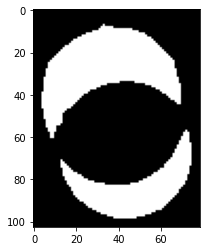

In [9]:
img = np.invert(img)
shadow = img > 0
clean = remove_small_objects(shadow, min_size=300)
clean = remove_small_objects(clean, min_size=300)
clean = np.uint8(clean)
plt.imshow(clean, cmap='gray')

### Rotate and Distance Transform

We want to measure how far the shadows stretch from the walls, both inner and outer. This means by rotating and applying a simple distance transform, we can determine the shadow length.

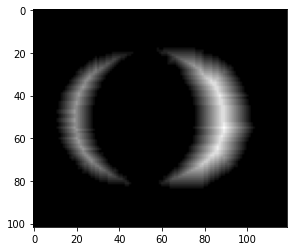

In [10]:
img_rot = copy.copy(clean)
img_rot = rotate(img_rot, -104, reshape=True)
img_trans = img_rot.copy()
dists = cv2.distanceTransform(img_trans, cv2.DIST_L1, 5)

plt.imshow(dists, cmap='gray')

## Assumption: shadows on opposite halves

Assuming that the bounding box detection is evenly centered around both the storage tank and the surrounding shadow, we can safely assume that each shadow will exist on opposing halves of the image. This means we can split our width calculations, giving the first half to the inner shadow, and second to outer.  

In [11]:
inside_shadow_widths = []
inside_positions = []
outside_shadow_widths = []
outside_positions = []

for i, row in enumerate(dists):
    
    row_widths = [j for j in row]
    
    in_widths = row_widths[:(int(0.5*len(row_widths)))]
    out_widths = row_widths[(int(0.5*len(row_widths))):]
    
    inside_shadow_widths.append(max(in_widths)*2)
    outside_shadow_widths.append(max(out_widths)*2)
    
    xpos_in = in_widths.index(max(in_widths))
    xpos_out = out_widths.index(max(out_widths))
    
    inside_positions.append((i, xpos_in))
    outside_positions.append((i, xpos_out+int(0.5*len(row_widths))))

### Shadow Length Profile 

In [21]:
inside_shadow = [(w, pos) for w, pos in zip(inside_shadow_widths, inside_positions)]
outside_shadow = [(w, pos) for w, pos in zip(outside_shadow_widths, outside_positions)]


(30.0, (55, 89))


Text(0.5, 1.0, 'Outside Shadow Length Profile')

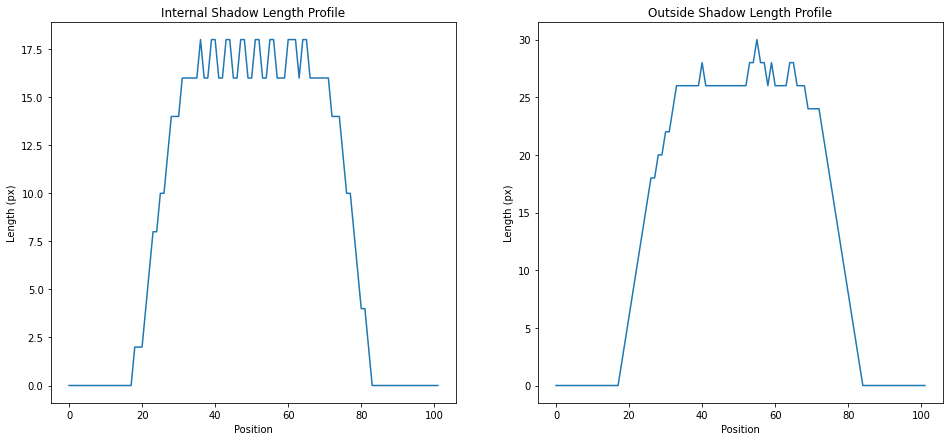

In [13]:
f = plt.figure(figsize=(16,7))
f.add_subplot(121)
plt.plot(range(dists.shape[0]), inside_shadow_widths)
plt.ylabel('Length (px)')
plt.xlabel('Position')
plt.title('Internal Shadow Length Profile')
f.add_subplot(122)
plt.plot(range(dists.shape[0]), outside_shadow_widths)
plt.ylabel('Length (px)')
plt.xlabel('Position')
plt.title('Outside Shadow Length Profile')

In [29]:
l1 = (18.0, (51, 19))
l2 = (28.0, (55, 89))

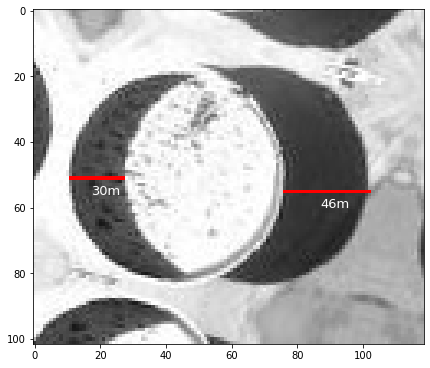

In [32]:
lengths = [l1, l2]

img = cv2.imread('tank_3.jpg')
img_rot = rotate(img, -104, reshape=True, mode='reflect')

plt.figure(figsize=(7,7))

for l in lengths:
    cv2.line(img_rot, (l[1][1] - (int(0.5*l[0]))+ 1, l[1][0]), (l[1][1] + (int(0.5*l[0])) - 1, l[1][0]), (255,0,0), 1)
    plt.annotate(s='{}m'.format(round(l[0]*PX_TO_M)), xy=(l[1][1] - 2, l[1][0] + 5), xytext=(l[1][1] - 2, l[1][0] + 5), color='w', fontsize=13, clip_on=True)
    
plt.imshow(img_rot, cmap='gray')

### Imperfections

The rim of the tank may be disturbing measurements. This could be dealt with by further smoothing or edge detection. 

### Storage Calculation 

Using basic formulae for the volume of a cylinder, we can use the difference in shadow lengths to approximate the occupied volume of the tank. 

In [34]:
INNER_LENGTH = l1[0] * PX_TO_M
OUTER_LENGTH = l2[0] * PX_TO_M

inner_shadow_start = l1[1][1] - int(INNER_LENGTH/2)
outer_shadow_start = l2[1][1] - int(OUTER_LENGTH/2)

TANK_DIAMETER = ((outer_shadow_start - inner_shadow_start) * PX_TO_M) +  5 
TANK_HEIGHT = 30 # approximation from http://alloiltank.com/crude-oil-storage-tanks/

TANK_FULL_VOLUME = math.pi * (int(TANK_DIAMETER//2) ^ 2) * TANK_HEIGHT

SHADOW_RATIO = INNER_LENGTH / OUTER_LENGTH

TANK_OCCUPANCY = TANK_FULL_VOLUME * SHADOW_RATIO

BARREL_PER_M3 = 0.158987

print('The tank has an estimated {} barrels of oil'.format(int(TANK_OCCUPANCY/BARREL_PER_M3)))

The tank has an estimated 205786 barrels of oil


# 7. Production Estimation (High Level)

### 1. Automation of the above process.

    1.1 Acquire bounding box detections of an entire refinery.
    
    1.2 Using knowledge of solar elevation can automate rotation for splitting shadows. 
    
    1.3 Run calculation for each tank and sum for facility. 
    
### 2. Repeat per imaged facility or generalise from one. 
   

### 3. Fuse with other data sources
    
    1. Oil tanker traffic
    
    2. Government forecasts
    
    3. Company statistics. 
    
    4. Trading activity. 